# Project 2
### 1.1 Finite Difference Operator
$$D_x = [1,  -1], D_y = [1,  -1]^T$$

First, show the partial derivative in x and y of the cameraman image by convolving the image with finite difference operators D_x and D_y (you can use convolve2d from scipy.signal library). Now compute and show the gradient magnitude image. To turn this into an edge image, lets binarize the gradient magnitude image by picking the appropriate threshold (trying to suppress the noise while showing all the real edges; it will take you a few tries to find the right threshold).

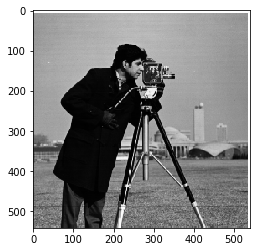

In [105]:
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import cv2
from scipy.ndimage.interpolation import rotate
import seaborn as sns
path = 'site/assets/imgs/'
import warnings
warnings.filterwarnings("ignore")

cameraman = io.imread('cameraman.png', as_gray=True)
plt.imshow(cameraman, cmap='gray');
plt.imsave(path+'camman.png', cameraman, cmap='gray')

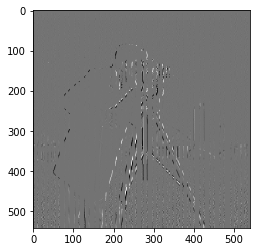

In [2]:
identity = np.array([[1,0], [0,1]])
dy = np.reshape(np.array([1,-1]), (2,1))
dx = np.reshape(np.array([1,-1]), (1,2))
x_partial = convolve2d(cameraman, dx, 'same')
plt.imshow(x_partial, cmap='gray')
plt.imsave(path+'x_partial.png', x_partial, cmap='gray')


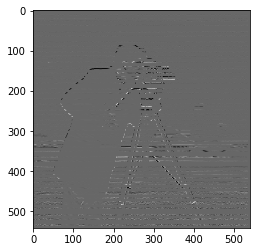

In [3]:
y_partial = convolve2d(cameraman, dy, 'same')
plt.imshow(y_partial, cmap='gray')
plt.imsave(path+'y_partial.png', y_partial, cmap='gray')


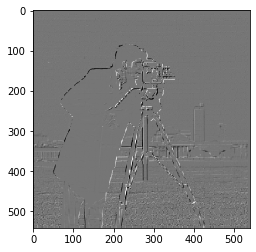

In [4]:
img_gradient = convolve2d(cameraman, np.array([[1,0], [0, -1]]), 'same')
plt.imshow(img_gradient, cmap = 'gray')
plt.imsave(path+'gradient.png', img_gradient, cmap='gray')


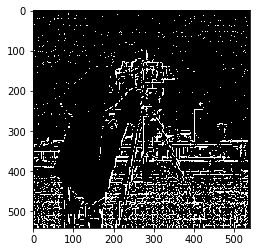

In [5]:
binary_x = np.where(img_gradient>.02, 1, 0)
plt.imshow(binary_x, cmap='gray')
plt.imsave(path+'binary_gradient.png', binary_x, cmap='gray')


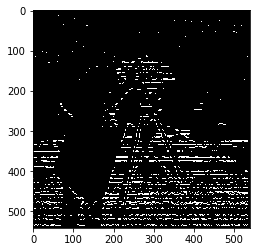

In [6]:
binary_y = np.where(y_partial>.03, 1, 0)
plt.imshow(binary_y, cmap='gray')

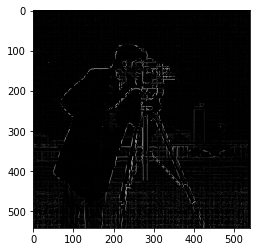

In [7]:
combined = np.sqrt(np.square(x_partial)+np.square(y_partial))
plt.imshow(combined, cmap='gray')
plt.imsave(path+'edge.png', combined, cmap='gray')


## 1.2 DoG filter
We noted that the results with just the difference operator were rather noisy. Luckily, we have a smoothing operator handy: the Gaussian filter G. Create a blurred version of the original image by convolving with a gaussian and repeat the procedure in the previous part (one way to create a 2D gaussian filter is by using cv2.getGaussianKernel() to create a 1D gaussian and then taking an outer product with its transpose to get a 2D gaussian kernel). What differences do you see? Now we can do the same thing with a single convolution instead of two by creating a derivative of gaussian filters. Convolve the gaussian with D_x and D_y and display the resulting DoG filters as images. Verify that you get the same result as before.

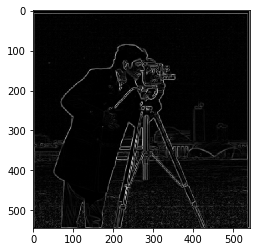

In [9]:
gaussian = np.array([[1,2,1], [2,4,2], [1,2,1]])/16
blurred = convolve2d(cameraman, gaussian)
x_partial, y_partial = convolve2d(blurred, dx, 'same'), convolve2d(blurred, dy, 'same')
combined = np.sqrt(np.square(x_partial)+np.square(y_partial))
plt.imshow(combined, cmap='gray')

## 1.3  Image Straightening

Remember the last time when you took a photo from your phone and the image was not straight. You probably tried rotating the image manually to straighten it. In this problem, you will automate the image straightening process to save some time! It is known that statistically there is a preference for vertical and horizontal edges in most images (due to gravity!). We will use this insight by trying to rotate an image to maximize the number of vertical and horizontal edges. To straighten an image, generate a set of proposed rotations. For each proposed rotation angle --

- Rotate the image by the proposed rotation angle using the built in rotation function in python/matlab (e.g. scipy.ndimage.interpolation.rotate in python).
- Compute the gradient angle of the edges in the image (but ignore the edges of the image created by rotation itself; one simple way of doing this is to always crop the center part of the image).
- Compute a histogram of these angles (e.g. matplotlib.pyplot.hist in python).

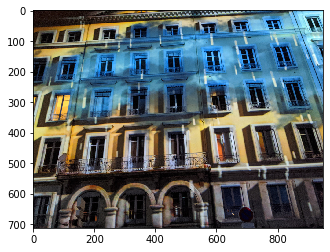

In [10]:
from PIL import Image
straight = plt.imread('straight.jpg')
straight = cv2.resize(straight, (int(straight.shape[1]*.25), int(straight.shape[0]*.25)))
plt.imshow(straight)

gradient angle$(\theta) = tan^{-1} \frac{g_y}{g_x}$ where $g_x = \frac{\partial f}{\partial x}$ and $g_y = \frac{\partial f}{\partial y}$

In [150]:
def reject_outliers(data, cutoff = 50):
    return data[abs(data) < cutoff]

def gradient_angle_hist(img, save=False, name='img.png'):
    #just going to compute using the first color chanel because it should be the same
    img = crop(img)
    r = img[:,:,0]
    partial_x, partial_y = convolve2d(r, dx, 'same'), convolve2d(r, dy, 'same')
    arr = np.arctan(partial_y/partial_x).flatten()
    arr = reject_outliers(arr, 2)
    arr = arr[np.logical_not(np.isnan(arr))]
    sns.distplot(arr)
    plt.title('Gradient Angle Histogram')
    plt.ylabel('Normalized frequency')
    plt.xlabel('Normalized angle')
    if save:
        plt.savefig(name)
        plt.close()
    return arr
    

In [232]:
def rotation_loss(img):
    img = crop(img)
    r = img[:,:,0]
    partial_x, partial_y = convolve2d(r, dx, 'same'), convolve2d(r, dy, 'same')
    loss = np.sum(np.abs(partial_x)) + np.sum(np.abs(partial_y))
    return loss

def crop(img, percent = .9):
    x, y, z = img.shape
    return img[int(-x*percent):int(x*percent), int(-y*percent):int(y*percent),:]

In [268]:
def find_best_rotation(img, range_ = (-7, 8), save_data=False):
    data = []
    for angle in np.arange(range_[0], range_[1], .5):
        test_img = rotate(img, angle, reshape=False)
        cropped = crop(test_img)
        loss = rotation_loss(cropped)
        if save_data:
            x = gradient_angle_hist(cropped, save=True, name='rotations/' + str(angle)+'.png')
            plt.imsave('rotations/' + str(angle)+'_img.png', test_img)
        data.append((loss, angle))
    best_loss, best_angle = min(data)
    print("Angle:" ,  best_angle)
    return rotate(img, best_angle, reshape=False)

In [197]:
munich = rescale(plt.imread('munich.jpg'),.12)
lse = rescale(plt.imread('lse.jpg'), .12)
grese = rescale(plt.imread('grece.jpg'), .12)
unit3 = rescale(plt.imread('unit3.jpg'),.12)

In [192]:
gradient_angle_hist(munich, True, 'munich_hist.jpg')
gradient_angle_hist(lse, True, 'lse_hist.jpg')
gradient_angle_hist(grese, True, 'grece_hist.jpg')
gradient_angle_hist(unit3, True, 'unit3_hist.jpg')

array([ 0.78539816, -1.06172544,  1.43170039, ..., -1.57079633,
       -1.24904577, -0.46364761])

In [198]:
unit3.shape

(363, 484, 3)

In [202]:
mun_r = np.clip(find_best_rotation(munich),0,1)
lse_r = np.clip(find_best_rotation(lse),0,1)
g_r = np.clip(find_best_rotation(grese),0,1)
unit3_r = np.clip(find_best_rotation(unit3),0,1)
plt.imsave('mun_r.jpg', mun_r)
plt.imsave('lse_r.jpg', lse_r)
plt.imsave('g_r.jpg', g_r)
plt.imsave('unit3_r.jpg', unit3_r)

Angle: 0.0
Angle: -6.5
Angle: 0.0
Angle: -7.0


In [203]:
gradient_angle_hist(mun_r, True, 'munich_r_hist.jpg')
gradient_angle_hist(lse_r, True, 'lse_r_hist.jpg')
gradient_angle_hist(g_r, True, 'grece_r_hist.jpg')
gradient_angle_hist(unit3_r, True, 'unit3__r_hist.jpg')

array([ 0.78539816,  1.26511159, -1.38941391, ..., -1.48873567,
       -1.36849265, -1.15620099])

Angle: 7.5


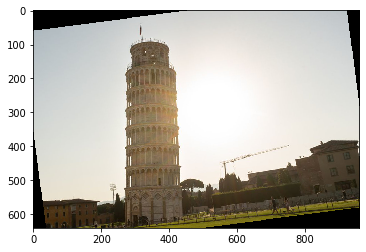

In [269]:
rotated = find_best_rotation(pisa)
plt.imshow(rotated)

## Part 2
#### 2.1 Sharpening


In [259]:
def gkern(l=5, sig=1.):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

def low_pass(img, kernel = gaussian):
    img = img / img.max()
    if len(img.shape) == 3:
        r,g,b = img[:,:,0],  img[:,:,1],  img[:,:,2]
        r,g,b = convolve2d(r, kernel,'same'), convolve2d(g, kernel, 'same'), convolve2d(b, kernel, 'same')
        temp = np.dstack([r,g,b])
        return temp / temp.max()
    else: 
        t = convolve2d(img, kernel, 'same')
        return t/t.max()
    
def high_pass(img, kernel = gaussian, a=1):
    img = img / img.max()
    low = low_pass(img, kernel)
    temp = img - a*low
    return temp

def high_pass_filter(img):
    kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
    if len(img.shape) == 2:
        return convolve2d(img, kernel, 'same')
    else:
        r,g,b = img[:,:,0],  img[:,:,1],  img[:,:,2]
        r,g,b = convolve2d(r, kernel,'same'), convolve2d(g, kernel, 'same'), convolve2d(b, kernel, 'same')
        temp = np.dstack([r,g,b])
        return np.clip(temp, 0, 1)


def sharpen(img, alpha = .9):
    img = img / img.max()
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    r,g,b = img[:,:,0],  img[:,:,1],  img[:,:,2]
    r,g,b = convolve2d(r, kernel,'same'), convolve2d(g, kernel, 'same'), convolve2d(b, kernel, 'same')
    t = np.dstack([r,g,b])
    return np.clip(t, 0 ,1)

In [424]:
temp_dog = rescale(blurry_dog, .25)

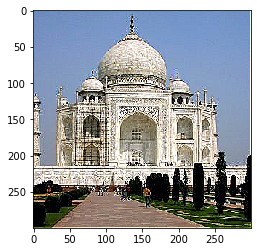

In [491]:
taj = plt.imread('taj.jpg')
plt.imshow(sharpen(taj))
plt.imsave(path+'sharpened.jpg', sharpen(taj))

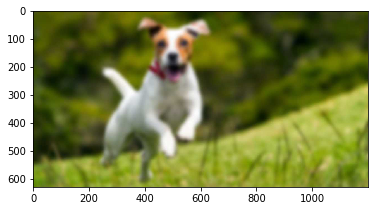

In [494]:
blurry_dog = plt.imread('blurry_dog.jpg')
plt.imshow(blurry_dog);
plt.imsave(path+'blurry_dog.jpg', blurry_dog)

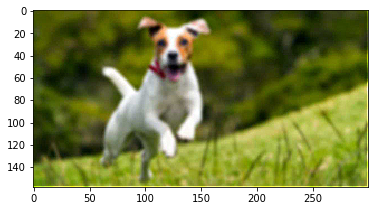

In [426]:
plt.imshow(sharpen(temp_dog, 4))
plt.imsave(path+'sharp_dog.jpg',sharpen(temp_dog))

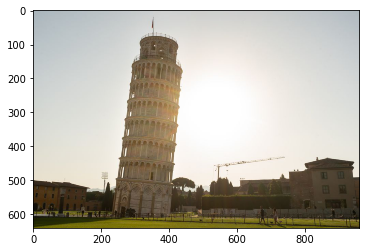

In [499]:
plt.imshow(low_pass(pisa))
plt.imsave(path+'blurred_pisa.jpg',low_pass(pisa))

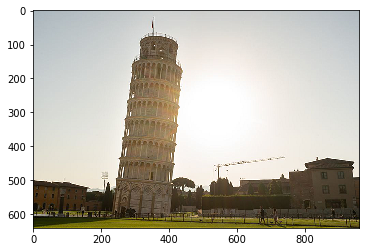

In [500]:
plt.imshow(sharpen(low_pass(pisa)))
plt.imsave(path+'resharpened_pisa.jpg',sharpen(low_pass(pisa)))

#### Part 2.2: Hybrid Images

###### Overview
The goal of this part of the assignment is to create hybrid images using the approach described in the SIGGRAPH 2006 paper by Oliva, Torralba, and Schyns. Hybrid images are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available, but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, you get a hybrid image that leads to different interpretations at different distances.

###### Details
Here, we have included two sample images (of Derek and his former cat Nutmeg) and some matlab starter code that can be used to load two images and align them. Here is the python version. The alignment is important because it affects the perceptual grouping (read the paper for details).

1. First, you'll need to get a few pairs of images that you want to make into hybrid images. You can use the sample images for debugging, but you should use your own images in your results. Then, you will need to write code to low-pass filter one image, high-pass filter the second image, and add (or average) the two images. For a low-pass filter, Oliva et al. suggest using a standard 2D Gaussian filter. For a high-pass filter, they suggest using the impulse filter minus the Gaussian filter (which can be computed by subtracting the Gaussian-filtered image from the original). The cutoff-frequency of each filter should be chosen with some experimentation.

2. For your favorite result, you should also illustrate the process through frequency analysis. Show the log magnitude of the Fourier transform of the two input images, the filtered images, and the hybrid image. In MATLAB, you can compute and display the 2D Fourier transform with with:
'imagesc(log(abs(fftshift(fft2(gray_image)))))' and in Python it's 'plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(gray_image)))))'

3. Try creating a variety of types of hybrid images (change of expression, morph between different objects, change over time, etc.).

**Bells & Whistles (Extra Points)**

Try using color to enhance the effect. Does it work better to use color for the high-frequency component, the low-frequency component, or both? (2 points)

 

In [196]:
#images aligned with the python script then imported to prototype
from skimage.transform import rescale
d,c = plt.imread('align_cat.jpg'), plt.imread('align_derek.jpg')
c,d = rescale(c, .25), rescale(d, .25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


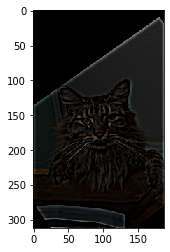

In [552]:
high = high_pass(c, .85, gkern(8, 11))
plt.imshow(high)

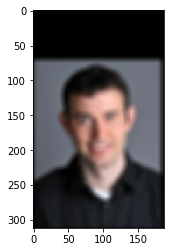

In [543]:
low = low_pass(d, gkern(l = 10, sig = 15))
plt.imshow(low)

In [261]:
def hybrid_img(close_img, far_img, kernel_1=gaussian, kernel_2=gaussian, bw=True, alpha=.85):
    """requires aligned images and stuff"""
    low = low_pass(far_img, kernel_1)
    high = high_pass(close_img, kernel_2, alpha)
    t = low+high
    if bw and len(high.shape)==3:
        return np.clip(t[:,:,0], 0 ,1)
    else:
        return np.clip(t, 0, 1)

    

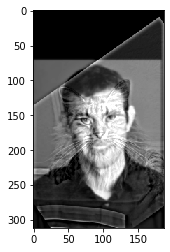

In [576]:
img  = hybrid_img(c, d, gkern(4, 1), gkern(10, 15))
plt.imshow(img, cmap='gray')

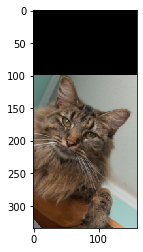

In [581]:
#images aligned with the python script then imported to prototype
from skimage.transform import rescale
d,c = plt.imread('im1.jpg'), plt.imread('im2.jpg')
c,d = rescale(c, .25), rescale(d, .25)
plt.imshow(c)

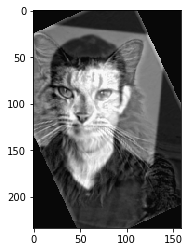

In [593]:
img  = hybrid_img(c, d, gkern(4, 1), gkern(10, 15))[100:, :]

plt.imshow(rotate(img, 25, reshape=False), cmap='gray')
plt.imsave(path+'hybrid_test.jpg', rotate(img, 25, reshape=False), cmap='gray')


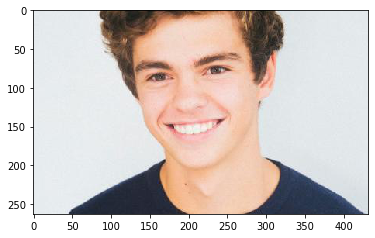

In [207]:
pav = plt.imread('im2.jpg')
beav = plt.imread('im1.jpg')
plt.imshow(pav)

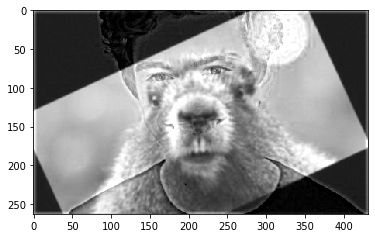

In [251]:
img  = hybrid_img(pav, beav, gkern(4, 1), gkern(10, 15))
plt.imshow(img, cmap='gray')
plt.imsave(path+'pav_beav.jpg', img, cmap='gray')

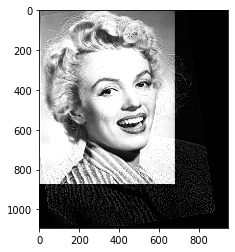

In [263]:
einstein, minroe = plt.imread('einstein.jpg'), plt.imread('minroe.jpg')
img  = hybrid_img(einstein, minroe, gkern(4, 1), gkern(10, 15))
plt.imshow(img, cmap='gray')
plt.imsave(path+'einstien_monroe.jpg', img, cmap='gray')

### Part 2.3: Gaussian and Laplacian Stacks


In [61]:
def gaussian_stack(img, height=5, init_sig=1):
    pics, size = [], 5
    for x in range(height+1):
        pic = low_pass(img, gkern(size, init_sig))
        pics.append(pic)
        init_sig *= 2
        size += 3
    return pics
        

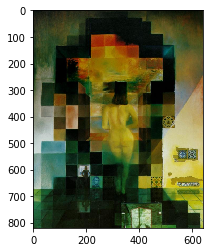

In [57]:
stack = plt.imread('stack0.jpg')
plt.imshow(stack)

In [102]:
data = gaussian_stack(stack)


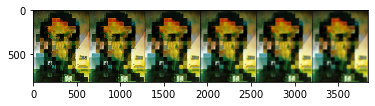

In [113]:
def show_hor(array_of_imgs):
    x,y,z = array_of_imgs[0].shape
    num = len(array_of_imgs)
    temp = np.stack(array_of_imgs, axis=1).reshape((x,num*y,z))
    return temp

concat = np.stack(data, axis = 1).reshape((820, 6*640, 3))
plt.imshow(concat)
plt.imsave(path+'gaussian_stack.jpg', concat)

In [105]:
def laplacian_stack(img, height=5, init_sigma=1):
    pics, size = [], 5
    for x in range(height+1):
        pic = high_pass(img, gkern(size, init_sigma))
        pics.append(pic)
        init_sigma *= 2
        size += 3
    return pics

In [106]:
laplacian = laplacian_stack(stack)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


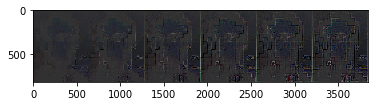

In [112]:
concat2 = np.stack(laplacian, axis = 1).reshape((820, 6*640, 3))
plt.imshow(concat2+.2)
plt.imsave(path+'laplacian_stack.jpg', np.clip(concat2+.2, 0, 1))

### Part 2.4: Multiresolution Blending
**Overview**
The goal of this part of the assignment is to blend two images seamlessly using a multi resolution blending as described in the 1983 paper by Burt and Adelson. An image spline is a smooth seam joining two image together by gently distorting them. Multiresolution blending computes a gentle seam between the two images seperately at each band of image frequencies, resulting in a much smoother seam.

**Details**
Here, we have included the two sample images from the paper (of an apple and an orange).

1. First, you'll need to get a few pairs of images that you want blend together with a vertical or horizontal seam. You can use the sample images for debugging, but you should use your own images in your results. Then you will need to write some code in order to use your Gaussian and Laplacian stacks from part 2 in order to blend the images together. Since we are using stacks instead of pyramids like in the paper, the algorithm described on page 226 will not work as-is. If you try it out, you will find that you end up with a very clear seam between the apple and the orange since in the pyramid case the downsampling/blurring/upsampling hoopla ends up blurring the abrupt seam proposed in this algorithm. Instead, you should always use a mask as is proposed in the algorithm on page 230, and remember to create a Gaussian stack for your mask image as well as for the two input images. The Gaussian blurring of the mask in the pyramid will smooth out the transition between the two images. For the vertical or horizontal seam, your mask will simply be a step function of the same size as the original images.
2. Now that you've made yourself an oraple (a.k.a your vertical or horizontal seam is nicely working), pick a couple of images to blend together with an irregular mask, as is demonstrated in figure 8 in the paper.
3. Blend together some crazy ideas of your own!
4. Illustrate the process by applying your Laplacian stack and displaying it for your favorite result and the masked input images that created it. This should look similar to Figure 10 in the paper.

**Bells & Whistles (Extra Points)**
Try using color to enhance the effect. (2 points)
Tell us what is the coolest/most interesting thing you learned from this assignment!

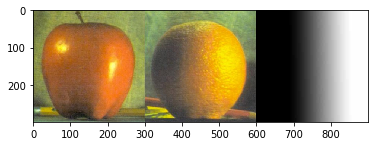

In [290]:
apple = plt.imread('apple.jpeg')
orange = plt.imread('orange.jpeg')
mask = plt.imread('gradient_mask.jpg')
plt.imshow(show_hor([apple, orange, mask]));

In [325]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


In [372]:
def blend_bw(im1, im2, mask, height=3, kernel=gkern(5, 3)):
    im1 = rgb2gray(im1)
    im2 = rgb2gray(im2)
    mask_bw = rgb2gray(mask)
    stack1 = laplacian_stack(im1, height)
    stack2 = laplacian_stack(im2, height)
    mask_stack = gaussian_stack(mask_bw, height)
    stack1_w = [np.array(x)*np.array(y) for x,y in zip(stack1, mask_stack)]
    stack2_w = [x*(1-y) for x,y in zip(stack2, mask_stack)]
    gauss1 = low_pass(im1, kernel)*mask_stack[2]
    gauss2 = low_pass(im2, kernel)*(1-mask_stack[2])
    stack1_w.append(gauss1)
    stack2_w.append(gauss2)
    combined_stack = [x+y for x,y in zip(stack1_w, stack2_w)]
    
    t = np.sum(np.array(combined_stack), axis=0)
    return (t - t.min()) / (t.max() - t.min())


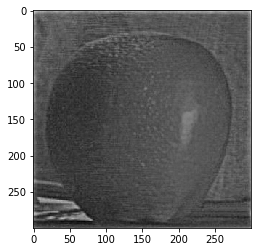

In [375]:
plt.imshow(blend_bw(apple, orange, mask), cmap='gray')

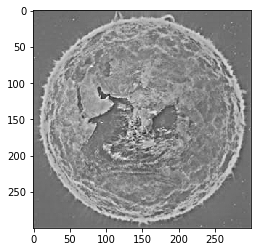

In [383]:
earth = plt.imread('earth.jpg')
star = plt.imread('star.jpg')
soft_mask = plt.imread('soft_gradient.jpg')
round_mask = plt.imread('round_mask.jpg')

plt.imshow(blend_bw(star, earth,round_mask), cmap='gray')
#plt.imsave(path+'stat_earth.jpg', blend_bw(earth, star,mask), cmap='gray')

In [413]:
def blend(im1, im2, mask, height=3, kernel=gkern(5, 3)):
    stack1 = laplacian_stack(im1, height)
    stack2 = laplacian_stack(im2, height)
    mask_stack = gaussian_stack(mask, height)
    stack1_w = [np.array(x)*np.array(y) for x,y in zip(stack1, mask_stack)]
    stack2_w = [x*(1-y) for x,y in zip(stack2, mask_stack)]
    gauss1 = low_pass(im1, kernel)*mask_stack[2]
    gauss2 = low_pass(im2, kernel)*(1-mask_stack[2])
    stack1_w.append(gauss1)
    stack2_w.append(gauss2)
    combined_stack = [x+y for x,y in zip(stack1_w, stack2_w)]
    
    t = np.sum(np.array(combined_stack), axis=0)
    return (t - t.min()) / (t.max() - t.min())


In [400]:
#plt.imshow(color_orple)
#plt.imsave(path+'orple.jpg', color_orple)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


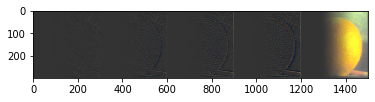

In [409]:
plt.imshow(show_hor(st1)+.2)
plt.imsave(path+'orange_stack.jpg', np.clip(show_hor(st1)+.2,0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


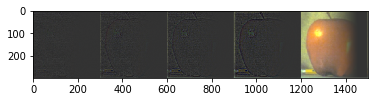

In [410]:
plt.imshow(show_hor(st2)+.2)
plt.imsave(path+'apple_stack.jpg', np.clip(show_hor(st2)+.2,0,1))

In [411]:
eye, galaxy, eye_mask = plt.imread('eye copy.jpg'), plt.imread('gal.jpg'), plt.imread('eye_mask.jpg')

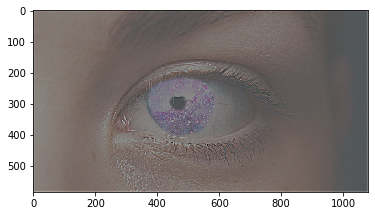

In [427]:
galaxy_eye = blend(eye, galaxy, eye_mask)
plt.imshow(galaxy_eye)

In [417]:
#plt.imsave(path+'gal_eye.jpg', galaxy_eye)